<a href="https://www.kaggle.com/code/werakaggle/time-series-forecasting-methods-part-iii-lstm?scriptVersionId=119681410" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Time series forecasting methods part III

## The Long Short-Term Memory network

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

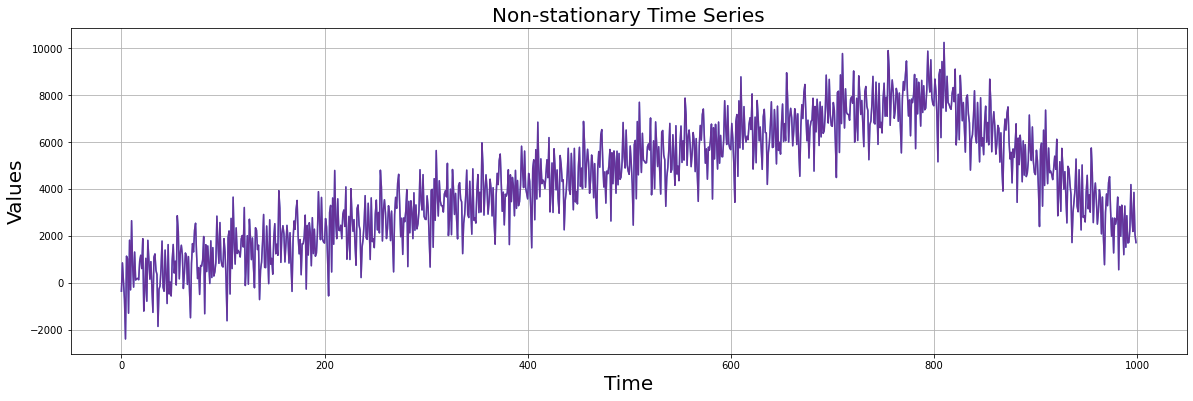

In [2]:
np.random.seed(6)

values = np.random.randn(200)*1000
seasonal = []
for i in range(10):   #10 seasons
    for j in range(100):
        seasonal.append(values[j])
        
noise = np.random.randn(1000)*100
seasonal += noise
seasonal_upward = seasonal + np.arange(1000)*10
big_event = np.zeros(1000)
big_event[-200:] = np.arange(200)*-40
non_stationary = seasonal_upward  + big_event
time = np.arange(1000)


# now get our synthetic data into a dataframe and set 
df = pd.DataFrame({'time': time,
                   'values': non_stationary})
df=df.set_index(['time'])

# and visualise it
plt.figure(figsize=(20,6))
plt.plot(time, non_stationary, color="cornflowerblue")
plt.plot(time, df['values'], color='rebeccapurple')
plt.xlabel("Time", fontsize=20)
plt.ylabel("Values", fontsize=20)
plt.title("Non-stationary Time Series", fontsize=20)
plt.grid(True)
    

### Data Normalization and Train/Test Split

In [3]:
dataset = df.values
dataset = dataset.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.9)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

900 100


### Array of values into a dataset matrix

In [4]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [5]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Create and fit the LSTM network

In [6]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=1) # epochs 10

2023-02-19 21:24:49.213917: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-02-19 21:24:49.602272: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
898/898 [==============================] - 3s 1ms/step - loss: 0.0550
Epoch 2/50
898/898 [==============================] - 1s 1ms/step - loss: 0.0170
Epoch 3/50
898/898 [==============================] - 1s 1ms/step - loss: 0.0134
Epoch 4/50
898/898 [==============================] - 1s 1ms/step - loss: 0.0125
Epoch 5/50
898/898 [==============================] - 1s 1ms/step - loss: 0.0123
Epoch 6/50
898/898 [==============================] - 1s 1ms/step - loss: 0.0123
Epoch 7/50
898/898 [==============================] - 1s 1ms/step - loss: 0.0124
Epoch 8/50
898/898 [==============================] - 1s 1ms/step - loss: 0.0124
Epoch 9/50
898/898 [==============================] - 1s 1ms/step - loss: 0.0124
Epoch 10/50
898/898 [==============================] - 1s 1ms/step - loss: 0.0124
Epoch 11/50
898/898 [==============================] - 1s 1ms/step - loss: 0.0123
Epoch 12/50
898/898 [==============================] - 1s 1ms/step - loss: 0.0123
Epoch 13/50
898/898 [====

# Apply the model to predict

In [7]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1407.54 RMSE
Test Score: 1455.42 RMSE


## plotting predictions

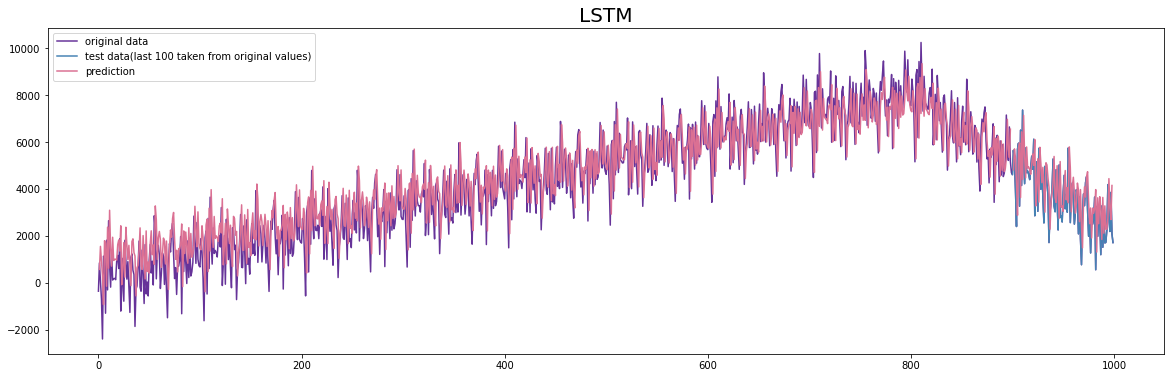

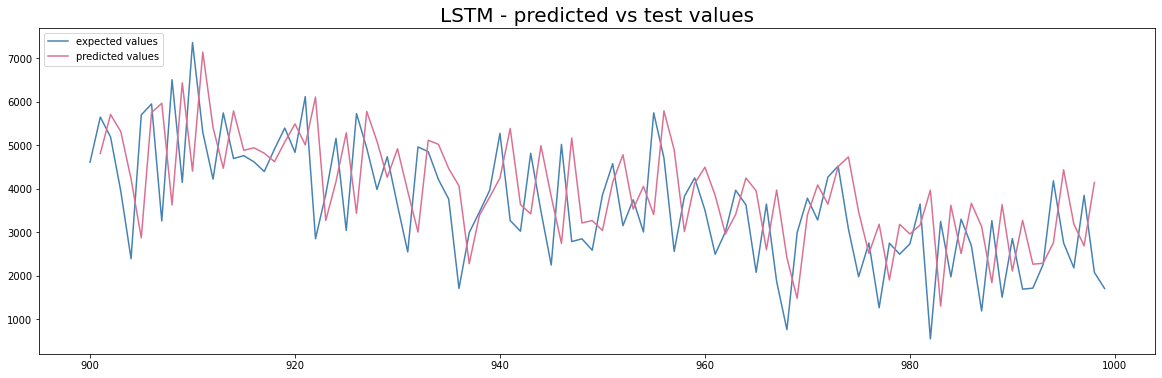

In [8]:
# shift train
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.figure(figsize=(20,6))
plt.plot(scaler.inverse_transform(dataset), color='rebeccapurple', label='original data')
plt.plot(time[-100:], scaler.inverse_transform(dataset)[-100:], color='steelblue', label='test data(last 100 taken from original values)')
plt.plot(trainPredictPlot, color='palevioletred')
plt.plot(testPredictPlot, color='palevioletred', label='prediction')
plt.legend(loc="upper left")
plt.title("LSTM", fontsize=20)
plt.show()


# plot baseline and predictions
plt.figure(figsize=(20,6))
plt.plot(time[-100:], scaler.inverse_transform(dataset)[-100:], color='steelblue', label='expected values')
plt.plot(time[-100:], testPredictPlot[-100:], color='palevioletred', label='predicted values')
# plt.plot(time[-100:], trainPredictPlot[-100:], color='palevioletred', label='prediction')
plt.title("LSTM - predicted vs test values", fontsize=20)
plt.legend(loc="upper left")
plt.show()

 ***


## XGBOOST
### see part II of this notebook
https://www.kaggle.com/werakaggle/time-series-forecasting-methods-part-ii-xgboost



## part I is available here:
https://www.kaggle.com/code/werakaggle/time-series-forecasting-methods-part-i

 ***

 
**References:**


Jason Brownlee. Machine Learning Mastery. (2022). *Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras.* https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/


See part I for full list of references